In [104]:
import pandas as pd
import bamboolib
import os
import datetime
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from IPython.core.display import display, HTML
import re

## Analyse des segments

In [3]:
aymeric =  "/home/aymeric/python-scripts/anses_medialab/datas/" #aymeric
jp = 'd:/Projects/Medialab/Anses/' # Jean Philippe


path_base = aymeric
file_segmentation = f"{path_base}segmentation_common_freq.csv"

index=f"{path_base}index_alldefault_nameexhaustive_aymeric.csv"

all_corpus = f"{path_base}all_corpus_seg_with_sdhi_PI.csv"

#twittos = f"{path_base}tweets_pesticides/500_first_twittos_on_pesticides.csv"

data_file = path_base+'fb_tw_med_data.csv.gz'#,line_terminator='\n',index=False)


In [4]:
list_base = ["index", "all_corpus"]
which_base = list_base[0]

In [5]:
if which_base == "all_corpus":
    df0 = pd.read_csv(all_corpus, sep = "\t")
else:
    df_index = pd.read_csv(index, sep = "\t")
    dfseg0 = pd.read_csv(file_segmentation, sep = "\t")

    df_index['date'] = pd.to_datetime(df_index['date'], infer_datetime_format=True)
    df_index['yearmonth']=(df_index['date'].dt.strftime('%Y-%m'))
    df_index['date'] = df_index['date'].dt.date
    
    segment = dfseg[["yearmonth", "segm", "origin"]]
    df0 = df_index.merge(segment, how = "inner", on = ["origin", "yearmonth"])
    df0["start_segment"] = df0.groupby(['origin','segm'])["date"].transform('min')
    df0["end_segment"] = df0.groupby(['origin','segm'])["date"].transform('max')

In [6]:
dft = pd.read_csv(data_file)

In [7]:
# Step: Rename column
segment = df0[["yearmonth", "segm", "origin"]]
dft = dft.rename(columns={'id': 'doc_id'})

dft['date'] = pd.to_datetime(dft['date'], infer_datetime_format=True)

dft['yearmonth']=(dft['date'].dt.strftime('%Y-%m'))
dft['date'] = dft['date'].dt.date
    
segment = dfseg[["yearmonth", "segm", "origin"]]
dft0 = dft.merge(segment, how = "inner", on = ["origin", "yearmonth"])
dft0["start_segment"] = dft0.groupby(['origin','segm'])["date"].transform('min')
dft0["end_segment"] = dft0.groupby(['origin','segm'])["date"].transform('max')



## Facebook

In [8]:
dfseg0 = dfseg.copy()

In [178]:
def filter_data(data, domain, segment):
    print(domain)
    dfseg = data[0]
    dfseg1 = dfseg.loc[(dfseg["origin"] == domain) & (dfseg["segm"] == segment)]
    
    df = data[1]
    df1 = df.loc[(df["origin"] == domain) & (df["segm"] == segment)]
    
    dft = data[2]
    dft1 = dft.loc[(dft["origin"] == domain) & (dft["segm"] == segment)]
    dft1['doc_id'] = dft1['doc_id'].astype('string')
    
    specific_terms = [x.strip() for x in dfseg1["top20_term_chi2_True"].iloc[0].split(",")]

    print(specific_terms)

    df1.loc[df1["term"].isin(specific_terms) == True, "in_top20_term"] = 1
    df1.loc[df1["term"].isin(specific_terms) == False, "in_top20_term"] = 0
    df2 = df1.drop_duplicates(subset = ["doc_id", "term"]).groupby(['doc_id', 'source', "date"]).agg(sum_of_top20_term =('in_top20_term', 'sum')).reset_index()

    df2 = df2.merge(dft1[["doc_id", "text"]], how = "inner", on = ["doc_id"])
    
    return dfseg1, df1, dft1, df2, specific_terms

In [197]:
domains = ["facebook", "twitter", "media"]
segment = 7
domain = domains[1]

list_df = [dfseg0, df0, dft0]
dfseg1, df1, dft1, df2, specific_terms = filter_data(list_df, domain = domain, segment = segment)

twitter


IndexError: single positional indexer is out-of-bounds

In [180]:
moyenne = np.mean(df2["sum_of_top20_term"]) 
df3 = df2.loc[df2["sum_of_top20_term"] >= 2 ]
df3 = df3.sort_values(by=['date'], ascending=[True])

df3 = df3.drop_duplicates(subset = "text")

In [181]:
nombre_texts = len(df3["text"])
start_segment = df1["start_segment"].iloc[1].strftime("%Y-%m-%d")
end_segment = df1["end_segment"].iloc[1].strftime("%Y-%m-%d")

for i, text in enumerate(df3["text"]):
    doc_id = df3["doc_id"].iloc[i]
    list_term = [x for x in df1["term"].loc[(df1["doc_id"] == doc_id)].unique()]
    list_top20_term = [x for x in df1["term"].loc[(df1["doc_id"] == doc_id) & (df1["in_top20_term"] == 1)].unique()]
    list_top20_term_absent = set(specific_terms) - set(list_top20_term)
    date = df3["date"].iloc[i].strftime("%Y-%m-%d")
    auteur = df3["source"].iloc[i]
    display(HTML(f"<h2 style='text-align:center;'> Texte {doc_id} ({i+1} sur {nombre_texts})</h2>"))
    display(HTML(f"<strong>Segment :</strong> {segment} ({start_segment} ; {end_segment})"))
    display(HTML(f"<strong>Date :</strong> {date}"))
    display(HTML(f"<strong>Auteur :</strong> {auteur} \n"))
    print(f"Termes indexés : {list_term} \n")
    print(f"Termes spécifiques présents : {list_top20_term} \n")
    print(f"Termes spécifiques absents : {list_top20_term_absent} \n")
    try:
        for j, term in enumerate(list_term):
            if term not in list_top20_term:
                text = re.sub(term, f'<mark style="background-color:yellow">{term}</mark>', text, flags=re.I)  
            else:
                text = re.sub(term, f'<mark style="background-color:pink">{term}</mark>', text, flags=re.I)  
        display(HTML(f'{text}'))
    except:
        print(f"{text} \n")
   

Termes indexés : ['vins', 'résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['vins', 'résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'plainte'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['ogm', 'roundup', 'malformations', 'désherbant', 'glyphosate'] 

Termes spécifiques présents : ['malformations', 'désherbant'] 

Termes spécifiques absents : {'développement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['ogm', 'roundup', 'malformations', 'désherbant', 'glyphosate'] 

Termes spécifiques présents : ['malformations', 'désherbant'] 

Termes spécifiques absents : {'développement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['malformations', 'désherbant', 'glyphosate', 'molécules', 'roundup', 'roundup de monsanto', 'monsanto'] 

Termes spécifiques présents : ['malformations', 'désherbant'] 

Termes spécifiques absents : {'développement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['désherbant', 'malformations'] 

Termes spécifiques présents : ['désherbant', 'malformations'] 

Termes spécifiques absents : {'développement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'pesticides', 'cancers'] 

Termes spécifiques présents : ['expositions', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'frelon', 'ogm', 'apiculteur'] 

Termes spécifiques présents : ['pesticides', 'frelon'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'frelon', 'apiculteur', 'unaf'] 

Termes spécifiques présents : ['pesticides', 'frelon'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'frelon', 'ogm', 'apiculteur'] 

Termes spécifiques présents : ['pesticides', 'frelon'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['abeilles', 'frelon', 'pesticides'] 

Termes spécifiques présents : ['frelon', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'frelon', 'ogm', 'apiculteur'] 

Termes spécifiques présents : ['pesticides', 'frelon'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'monsanto', 'cassation'] 

Termes spécifiques présents : ['pesticides', 'cassation'] 

Termes spécifiques absents : {'développement', 'troubles', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'bisphénol', 'bisphénol a', 'débat'] 

Termes spécifiques présents : ['pesticides', 'bisphénol', 'bisphénol a'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'nature environnement'} 



Termes indexés : ['malformations', 'pesticides'] 

Termes spécifiques présents : ['malformations', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['vins', 'résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'vitamines'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'études'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 

http://bit.ly/aR8MysDes <mark style="background-color:yellow">résidus</mark> de <mark style="background-color:pink">pesticides</mark> dans huit fruits sur dix 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'développement'] 

Termes spécifiques présents : ['pesticides', 'développement'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'limite', 'limites maximales'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['développement', 'pesticides'] 

Termes spécifiques présents : ['développement', 'pesticides'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['avis', 'campagne', 'pesticides', 'développement'] 

Termes spécifiques présents : ['pesticides', 'développement'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'céréaliers', 'céréalier charentais'] 

Termes spécifiques présents : ['pesticides', 'céréalier charentais'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['paul françois', 'victimes', 'victimes de pesticides', 'pesticides', 'céréaliers', 'céréalier charentais'] 

Termes spécifiques présents : ['pesticides', 'céréalier charentais'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'céréaliers', 'céréalier charentais', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'céréalier charentais'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'céréaliers', 'céréalier charentais', 'monsanto', 'écologique'] 

Termes spécifiques présents : ['pesticides', 'céréalier charentais'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires', 'paris'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 

http://bit.ly/d1Spfj <mark style="background-color:pink">pesticides</mark> : un rapport parlementaire demande la simplification de la reglementation 



Termes indexés : ['pesticides', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cour', "cour d'appel", 'pesticides', 'apiculture'] 

Termes spécifiques présents : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires', 'lobbies'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires', 'problème'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques présents : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['ecologie', 'parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques présents : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques présents : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques présents : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques présents : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques présents : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'effet', 'santé', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires', 'santé'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques présents : ['cour', "cour d'appel", 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'santé', 'nature', 'nature environnement'] 

Termes spécifiques présents : ['pesticides', 'nature environnement'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['désherbant', 'malformations'] 

Termes spécifiques présents : ['désherbant', 'malformations'] 

Termes spécifiques absents : {'développement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['développement', 'pesticides'] 

Termes spécifiques présents : ['développement', 'pesticides'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'santé', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'santé', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'santé', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'santé', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pollution', 'parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pollution', 'parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pollution', 'parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['politique', 'parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'santé', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides', 'développement'] 

Termes spécifiques présents : ['parlementaires', 'pesticides', 'développement'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'santé', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'santé', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'santé', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides', 'santé'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['martinique', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['martinique', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['vins', 'pesticides', 'développement'] 

Termes spécifiques présents : ['pesticides', 'développement'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['vins', 'pesticides', 'développement'] 

Termes spécifiques présents : ['pesticides', 'développement'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'problème', 'santé'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'cour', "cour d'appel"] 

Termes spécifiques présents : ['pesticides', 'cour', "cour d'appel"] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['troubles', 'pesticides'] 

Termes spécifiques présents : ['troubles', 'pesticides'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['troubles', 'pesticides'] 

Termes spécifiques présents : ['troubles', 'pesticides'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['troubles', 'pesticides'] 

Termes spécifiques présents : ['troubles', 'pesticides'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['troubles', 'pesticides', 'santé'] 

Termes spécifiques présents : ['troubles', 'pesticides'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['études', 'pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['études', 'troubles', 'pesticides'] 

Termes spécifiques présents : ['troubles', 'pesticides'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['antilles', 'pollution', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['martinique', 'guadeloupe', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['martinique', 'guadeloupe', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['martinique', 'guadeloupe', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['antilles', 'pollution', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'pesticides'] 

Termes spécifiques présents : ['parlementaires', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['antilles', 'pollution', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['antilles', 'pollution', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['martinique', 'guadeloupe', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'pesticides', 'cancers'] 

Termes spécifiques présents : ['expositions', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'chlordécone', 'guadeloupe'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles', 'monde'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles', 'monde'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires', 'paris'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['article', 'expositions', 'pesticides', 'troubles'] 

Termes spécifiques présents : ['expositions', 'pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles', 'chercheuse'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'développement', 'santé'] 

Termes spécifiques présents : ['pesticides', 'développement'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'développement', 'santé'] 

Termes spécifiques présents : ['pesticides', 'développement'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'vins'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'vins'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['algue', 'pesticides', 'désherbant'] 

Termes spécifiques présents : ['pesticides', 'désherbant'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['vins', 'santé', 'résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['vins', 'santé', 'résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cancers', 'chlordécone', 'pesticides'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'chlordécone', 'population', 'antilles'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'agriculture biologique', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'agriculture biologique', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'chlordécone', 'développement', 'cancers'] 

Termes spécifiques présents : ['expositions', 'chlordécone', 'développement'] 

Termes spécifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'chlordécone', 'développement', 'cancers'] 

Termes spécifiques présents : ['expositions', 'chlordécone', 'développement'] 

Termes spécifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cancers', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cancers', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'chlordécone', 'développement', 'cancers'] 

Termes spécifiques présents : ['expositions', 'chlordécone', 'développement'] 

Termes spécifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cancers', 'pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'chlordécone', 'cancers'] 

Termes spécifiques présents : ['expositions', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'cancers', 'pesticides'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'santé'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'pesticides'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'pesticides'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'pesticides'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'pesticides', 'santé'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'recherche', 'paris', 'parlementaires'] 

Termes spécifiques présents : ['chlordécone', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'chlordécone', 'développement', 'cancers'] 

Termes spécifiques présents : ['expositions', 'chlordécone', 'développement'] 

Termes spécifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'chlordécone', 'antilles', 'cancers'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'chlordécone'] 

Termes spécifiques présents : ['expositions', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'pesticides', 'santé'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'pesticides', 'santé'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['développement', 'pesticides'] 

Termes spécifiques présents : ['développement', 'pesticides'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'vins'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'pesticides'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['parlementaires', 'chlordécone'] 

Termes spécifiques présents : ['parlementaires', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'chlordécone', 'cancers'] 

Termes spécifiques présents : ['expositions', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['développement', 'pesticides'] 

Termes spécifiques présents : ['développement', 'pesticides'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'développement'] 

Termes spécifiques présents : ['pesticides', 'développement'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'pesticides', 'cancers'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cancers', 'chlordécone', 'développement'] 

Termes spécifiques présents : ['chlordécone', 'développement'] 

Termes spécifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cancers', 'chlordécone', 'développement'] 

Termes spécifiques présents : ['chlordécone', 'développement'] 

Termes spécifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['cancers', 'chlordécone', 'développement'] 

Termes spécifiques présents : ['chlordécone', 'développement'] 

Termes spécifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['développement', 'pesticides'] 

Termes spécifiques présents : ['développement', 'pesticides'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['développement', 'pesticides'] 

Termes spécifiques présents : ['développement', 'pesticides'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pollution', 'chlordécone', 'pesticides'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'pesticides', 'cancers'] 

Termes spécifiques présents : ['expositions', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'résidus', 'résidus de pesticides', 'ue'] 

Termes spécifiques présents : ['pesticides', 'résidus de pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'aliments'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'aliments', 'études'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'aliments'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'aliments'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'aliments'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'aliments'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['campagne', 'désherbant', 'pesticides'] 

Termes spécifiques présents : ['désherbant', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'pesticides', 'grossesse', 'cancers'] 

Termes spécifiques présents : ['expositions', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'bisphénol', 'bisphénol a', 'phtalates'] 

Termes spécifiques présents : ['pesticides', 'bisphénol', 'bisphénol a'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'nature environnement'} 



Termes indexés : ['pesticides', 'parlementaires'] 

Termes spécifiques présents : ['pesticides', 'parlementaires'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'bisphénol', 'bisphénol a', 'phtalates'] 

Termes spécifiques présents : ['pesticides', 'bisphénol', 'bisphénol a'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['ecologie', 'eau', 'pesticides', 'milieu', 'études'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu', 'études'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['virus', 'résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'pesticides'] 

Termes spécifiques présents : ['chlordécone', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'bisphénol', 'bisphénol a', 'phtalates'] 

Termes spécifiques présents : ['pesticides', 'bisphénol', 'bisphénol a'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu', 'développement'] 

Termes spécifiques présents : ['pesticides', 'milieu', 'développement'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pollution', 'pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['vins', 'résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'milieu'] 

Termes spécifiques présents : ['pesticides', 'milieu'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['santé', 'expositions', 'pesticides', 'problème'] 

Termes spécifiques présents : ['expositions', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['études', 'pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'pesticides'] 

Termes spécifiques présents : ['expositions', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'pesticides'] 

Termes spécifiques présents : ['expositions', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles', 'études'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['expositions', 'pesticides'] 

Termes spécifiques présents : ['expositions', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['études', 'pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'expositions', 'foetus', 'troubles', 'études'] 

Termes spécifiques présents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques présents : ['pesticides', 'expositions', 'foetus', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'bisphénol', 'nature environnement'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides'] 

Termes spécifiques présents : ['résidus de pesticides', 'pesticides'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['foetus', 'pesticides', 'troubles'] 

Termes spécifiques présents : ['foetus', 'pesticides', 'troubles'] 

Termes spécifiques absents : {'développement', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'chlordécone', 'antilles'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'développement'] 

Termes spécifiques présents : ['pesticides', 'développement'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'développement'] 

Termes spécifiques présents : ['pesticides', 'développement'] 

Termes spécifiques absents : {'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'chlordécone', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'développement'] 

Termes spécifiques présents : ['chlordécone', 'développement'] 

Termes spécifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['pesticides', 'chlordécone'] 

Termes spécifiques présents : ['pesticides', 'chlordécone'] 

Termes spécifiques absents : {'développement', 'troubles', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



Termes indexés : ['chlordécone', 'développement'] 

Termes spécifiques présents : ['chlordécone', 'développement'] 

Termes spécifiques absents : {'troubles', 'pesticides', 'cassation', "cour d'appel", 'frelon', 'bisphénol a', 'parlementaires', 'résidus de pesticides', 'foetus', 'malformations', 'désherbant', 'cour', 'milieu', 'confédération paysanne', 'céréalier charentais', 'expositions', 'bisphénol', 'nature environnement'} 



In [45]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


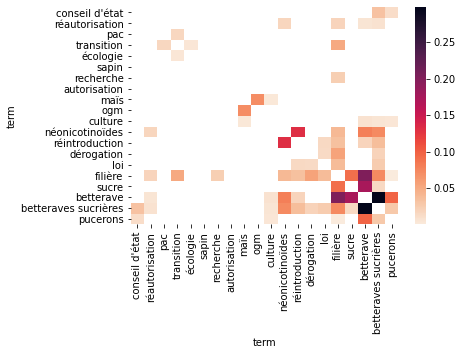

In [196]:
df11 = df1.loc[df1["in_top20_term"] ==  1]
df11["count_term"] = df11.groupby(['doc_id','term'])["in_top20_term"].transform('sum')
#df11["count_term2"] = df11.groupby(['term'])["doc_id"].transform('count')


t = pd.pivot_table(df11, index = "doc_id", columns = "term", values = "count_term", fill_value = 0)

corrMatrix = t.corr()


m = cluster_corr(corrMatrix)

mm = m.to_numpy()

for i in range(len(mm)):
    mm[i,i] = np.nan
    for j in range(len(mm)):
        if mm[i,j] <= 0:
            mm[i,j] = np.nan

cmap = sns.cm.rocket_r
sns.heatmap(m, cmap = cmap)
fig.set_size_inches(18.5, 10.5)

plt.savefig(f'segment{segment}_{domain}.png', bbox_inches='tight')

## Facebook

### 1ère période : 16 novembre 2011 -- 31 janvier 2012:1ère période (Segment 0)

<img src="segment0_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>



La première période sur facebook semble être caractérisée par trois thématiques:

- La première concerne le procès opposant Paul François (céréalier charantais) à Monsanto. Paul François s'est retrouvé dans le coma après avoir nettoyé une cuve contenant du Lasso (produit commercialisé par Monsanto). Le débat a débuté le 12 décembre 2011.

> pesticides : un agriculteur en procès contre monsanto Ce lundi 12 décembre 2011, paul françois, agriculteur victime des pesticides, sera en procès contre monsanto, en première instance, au TGI de Lyon, dans l'espoir de faire reconnaître la faute de la firme et d'engager la responsabilité de cette dernière. bioaddict.fr Nous en appelons à toutes celles et ceux qui le souhaitent à se rendre au TGI de Lyon le 12 décembre à 13h30 pour témoigner de leur soutien à paul françois et, ainsi, à toutes les victimes des pesticides. [Auteur : BIO ADDICT]

- Un deuxième ensemble de textes évoque le problème du déclin des pollinisateurs et, plus spécifiquemet, des abeilles. Les "termes spécifiques" du segment 0 que l'on retrouve dans ces textes sont par exemple : *'effet', 'pesticides', 'miel', 'parasite'*. **"Parasites"** et **"pesticides"** font référence à deux des causes supposées de disparition des abeilles (les pesticides à travers les néonicotinoïdes et les parasites avec le Varoa). Une disparition qui se manifesterait notamment par une baisse de production du **miel**.


> Fin des abeilles = fin du monde ? Oui bon, c’est peut-être un peu exagéré. Quoique…sans les abeilles, l’équilibre écologique serait gravement menacé. En effet, les abeilles ont un rôle essentiel pour la survie des végétaux depuis 50 millions d’années [...] On a découvert que les abeilles sont toxico-sensibles et donc plus vulnérables que la plupart des autres insectes aux <mark>pesticides</mark>. [...] En France, le Gaucho de Bayer et le Régent de BASF, deux insecticides accusés de ravager les abeilles, ont été interdits en 2006 mais malgré tout l’hécatombe se poursuit dans les ruches. On ne sait pas bien pourquoi et cela est très préoccupant. <mark>Certains apiculteurs soupçonnent que les pesticides</mark> toujours utilisés par l’agriculture sont à l’origine de ce qu’on appelle désormais le « syndrome d’effondrement des colonies », maladie dont on ne sait pas encore grand-chose. [...] Récemment, <mark>d’autres explications</mark> ont été données quant à la disparition des abeilles : 
> - <mark>Le frelon asiatique</mark> est montré du doigt. Cet insecte venu de l’étranger est un prédateur féroce pour les abeilles puisqu’il se nourrit de leurs larves. 
> - <mark>Une mouche parasite</mark> est également mise en cause depuis peu. Une étude américaine publiée en janvier 2012 a en effet mis en lumière le rôle néfaste de la mouche Apocephalus borealis. [Auteur: Let's save our Earth - Sauvons notre planète]

- Un troisième ensemble de textes porte sur le rapport publié par Génération futures sur les  résidus de pesticides dans l'alimentation

> Choisir de manger bio, c'est protéger sa santé L'association générations futures a effectué des tests comparant un menu conventionnel et un menu bio : le résultat est sans appel, le menu bio ne contenant quasiment aucun résidus de pesticides. "Il y a 223 fois moins de résidus de pesticides en moyenne dans les aliments bio analysés que dans les a... bioaddict.fr Mangez bio, c'est bon pour la santé ! Et ça, c'est vachement bien ! [Auteur : Les 2 vaches, industrie agroalimentaire]

- On trouve ensuite les textes qui prennent pour cible "Monsanto et son monde" ainsi que les effets sanitaires des produits commercialisés par la firme. Il s'agit probablement d'un ensemble de réactions à la suite de la sortie du film éponyme *Le monde selon Monsanto*.

> *Le monde selon Monsanto* : Ce film retrace l'histoire de monsanto, une multinationale américaine, aujourd'hui leader mondial des ogm, et considérée comme l'un des plus grands pollueurs de l'ère industrielle (PCB, agent orange, hormones de croissance, roundup...). Après une enquête de trois ans, en Amérique du nord et du sud, en europe et en Asie, il reconstitue la genèse d'un empire industriel, qui, à grand renfort de rapports mensongers, de collusion avec l'administration nord-américaine, de pressions et tentatives de corruption, est devenu l'un des premiers semenciers de la planète.

Il est intéressant de noter que Monsanto (et d'autres firmes comme Syngenta ou Bayer) semble être le lien entre différents "cluster": l'affaire Paul François, les débats liés au Roundup.

- Enfin, de nombreux posts évoquent les "pesticides" de façon générale sans faire de lien à une affaire en particulier.


### 2e période :  (Segment 1)

<img src="segment1_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 3ème période : (Segment 2)

<img src="segment2_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 4ème période : (Segment 3)

<img src="segment3_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 5ème période : (Segment 4)

<img src="segment4_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 6ème période : (Segment 5)

<img src="segment5_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 6ème période : (Segment 5)

<img src="segment5_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 7ème période : (Segment 6)

<img src="segment6_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 8ème période : (Segment 7)

<img src="segment7_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 9ème période : (Segment 8)

<img src="segment8_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 10ème période : (Segment 9)

<img src="segment9_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 11ème période : (Segment 10)

<img src="segment10_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 12ème période : (Segment 11)

<img src="segment11_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 13ème période : (Segment 12)

<img src="segment12_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

## Test (annexe)

In [ ]:
text = df2['text'].loc[(df2["doc_id"] == "413916")]
for x in text :
    print(x)

In [ ]:
text = """Santé Canada reçoit l'ordre de réexaminer les effets environnementaux du Roundup | equiterre.org 
- P La Cour fédérale du Canada a ordonné à Santé Canada de réévaluer sa décision de ne pas examiner les effets 
d'un herbicide, commercialisé sous le nom de Roundup. Ce pesticide est un des plus populaires sur le marché et 
il accompagne une proportion importante des plantes modifiées génétiquement utilis... equiterre.org 
Santé Canada reçoit l'ordre de la Cour fédérale de réexaminer les effets environnementaux du RoundUp!"""

In [ ]:
list_term = ["pesticides", "roundup"]

In [ ]:
import re
for j, term in enumerate(list_term):
    if term[-1]== "s":
        singular_term = term[0:-1]
    else:
        singular_term = term
    #text = text.replace(term[0:len(term)-1], f'<mark style="background-color:yellow">{term}</mark>')
    text = re.sub(term, f'<mark style="background-color:yellow">{term}</mark>', text, flags=re.I)          #

display(HTML(f'{text}'))